In [6]:
# ipython-input-2-98efb58b741c
# prompt: Download the Dataset
# using the kaggle path dataset
import kagglehub
# # Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Path to dataset files:", path)
# The dataset used in the project is "Brain MRI Images for Brain Tumor Detection." You can download it from Kaggle or any other source. Place the dataset in a folder named brain_tumor_dataset.
# Organize the Dataset
# The dataset should have the following structure:
# Copy
# brain_tumor_dataset/
# ├── yes/
# │   ├── image1.jpg
# │   ├── image2.jpg
# │   └── ...
# └── no/
#     ├── image1.jpg
#     ├── image2.jpg
#     └── ...

!pip install kaggle

# You need to upload your kaggle.json file to access datasets.
# You can find this file in your kaggle account settings.
# After uploading, run this command
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset

# Organize the dataset into the desired structure (yes/no folders).
# The provided dataset may need adjustment depending on its actual folder structure.
import os
import shutil

# Example path to the unzipped dataset (Adjust to your actual path).
dataset_path = 'brain_tumor_dataset/brain_tumor_dataset/'

yes_folder = 'brain_tumor_dataset/yes'
no_folder = 'brain_tumor_dataset/no'

if not (os.path.exists(yes_folder) and len(os.listdir(yes_folder)) > 0 and
        os.path.exists(no_folder) and len(os.listdir(no_folder)) > 0):

    os.makedirs(yes_folder, exist_ok=True)
    os.makedirs(no_folder, exist_ok=True)

    # ... (Your original code for moving files) ...
else:
    print("Dataset folders already organized. Skipping organization.")


import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
# Corrected IMG_PATH to point directly to the folder with 'yes' and 'no'
IMG_PATH = 'brain_tumor_dataset/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
TRAIN_DIR = 'TRAIN/'  # Define TRAIN_DIR

# Create directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'NO'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'NO'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'YES'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'NO'), exist_ok=True)

# Split the data
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.') and os.path.isdir(os.path.join(IMG_PATH, CLASS)):  # Ignore hidden files/folders and non-directory items
        class_path = os.path.join(IMG_PATH, CLASS)

        # List only files within the class folder
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        IMG_NUM = len(files)
        train_num = int(0.7 * IMG_NUM)  # 70% for training
        test_num = int(0.15 * IMG_NUM)  # 15% for testing
        val_num = IMG_NUM - train_num - test_num  # Remaining for validation

        for (n, FILE_NAME) in enumerate(files):
            img = os.path.join(class_path, FILE_NAME)  # Use class_path instead of IMG_PATH
            if n < test_num:
                shutil.copy(img, os.path.join(TEST_DIR, CLASS.upper(), FILE_NAME))
            elif n < test_num + train_num:
                shutil.copy(img, os.path.join(TRAIN_DIR, CLASS.upper(), FILE_NAME))
            else:
                shutil.copy(img, os.path.join(VAL_DIR, CLASS.upper(), FILE_NAME))

# ipython-input-6-98efb58b741c
import cv2
import numpy as np

def crop_imgs(set_name):
    cropped_images = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_images.append(img[y:y+h, x:x+w])
    return np.array(cropped_images)

def preprocess_imgs(set_name, img_size):
    set_name = [cv2.resize(img, img_size) for img in set_name]
    set_name = np.array(set_name)
    set_name = set_name.astype('float32') / 255.0
    return set_name

# ipython-input-7-98efb58b741c
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ipython-input-10-98efb58b741c
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # Import preprocess_input

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# You need to define validation_generator before using it in model.fit
# Assuming you have a validation data directory similar to TRAIN_DIR
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brain-mri-images-for-brain-tumor-detection.zip
replace brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/13 no

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 176 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 118s 20s/step - accuracy: 0.5115 - loss: 11.3344 - val_accuracy: 0.8000 - val_loss: 2.1099
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 21s/step - accuracy: 0.8097 - loss: 2.8008 - val_accuracy: 0.7250 - val_loss: 5.4129
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 135s 24s/step - accuracy: 0.7577 - loss: 3.3356 - val_accuracy: 0.8500 - val_loss: 1.1532
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 19s/step - accuracy: 0.7850 - loss: 3.3164 - val_accuracy: 0.6750 - val_loss: 6.2038
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 20s/step - accuracy: 0.7561 - loss: 3.3589 - val_accuracy: 0.7250 - val_loss: 5.7139
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 141s 19s/step - accuracy: 0.7749 - loss: 3.9170 - val_accuracy: 0.7500 - val_loss: 3.1709
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 19s/step - accuracy: 0.8384 - loss: 1.8277 - val_accuracy: 0.8500 - val_loss: 2.0722
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 114s 19s/step - accuracy: 0.8537 - loss: 1.2531 - val_accuracy: 0.8750 - val_loss

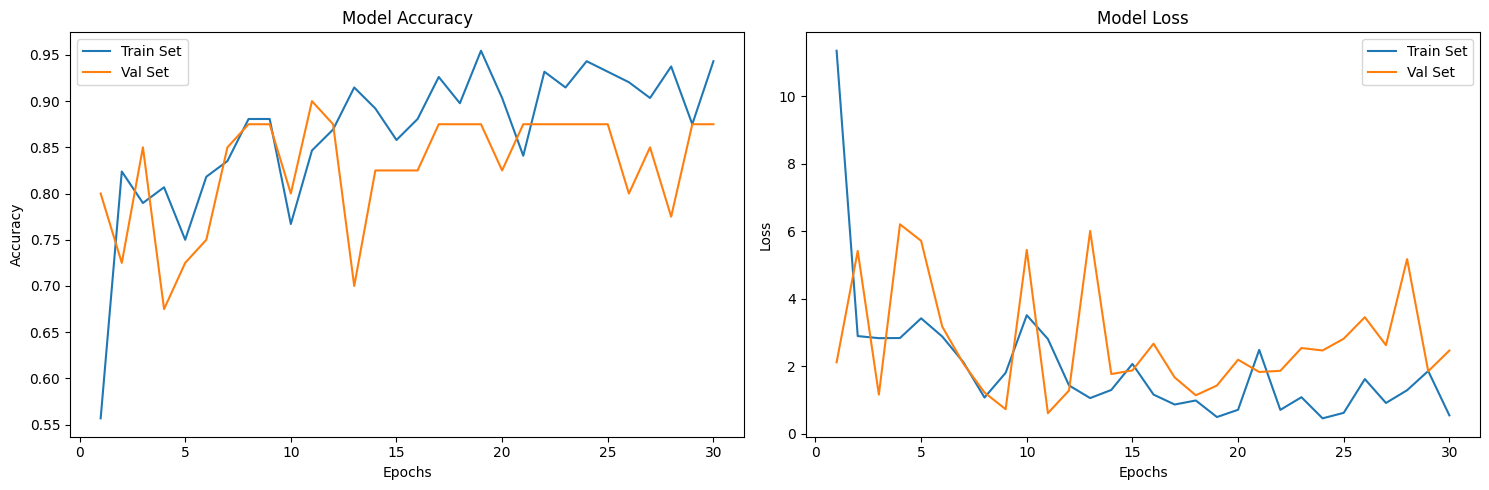

In [9]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5)) # Now you can use plt.figure() and other matplotlib functions

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Found 40 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
Val Accuracy = 0.88
Confusion matrix, without normalization
[[14  2]
 [ 2 14]]


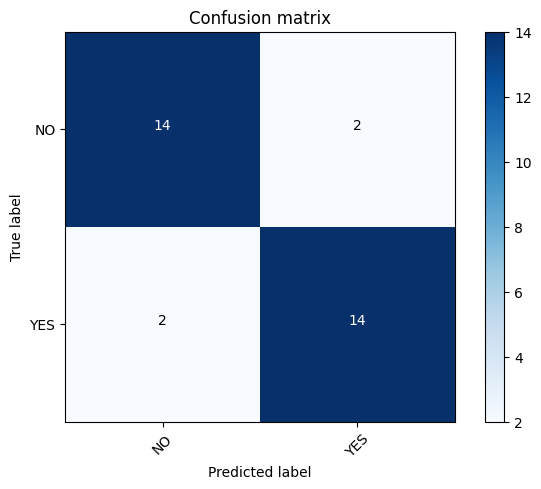

In [12]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools

# ... (previous code) ...

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Preprocess validation data
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    class_mode='binary',
    shuffle=False  # Important for consistent predictions
)

# Get X_val_prep and y_val
X_val_prep, y_val = next(validation_generator)

# Continue with predictions
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# ... (rest of the code) ...

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
# Assuming 'labels' is a dictionary mapping class indices to labels
# For example: labels = {0: 'No Tumor', 1: 'Tumor'}
labels = validation_generator.class_indices  # Get labels from the generator
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.keys()), normalize=False)

Found 37 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Test Accuracy = 0.91
Confusion matrix, without normalization
[[11  3]
 [ 0 18]]


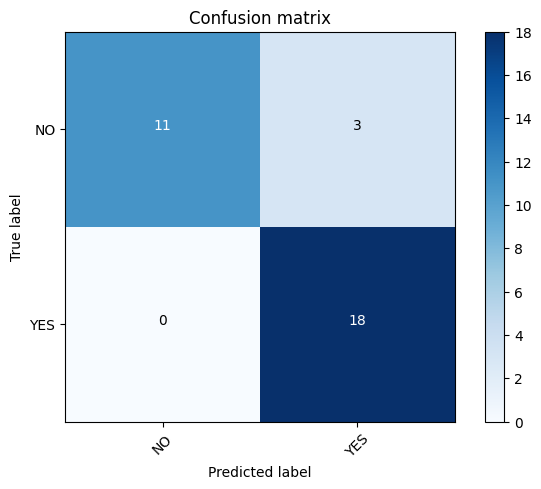

In [14]:
# Preprocess test data similar to validation data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size if needed
    class_mode='binary',
    shuffle=False  # Important for consistent predictions
)

# Get X_test_prep and y_test
X_test_prep, y_test = next(test_generator)

# Now you can make predictions on the test data
predictions = model.predict(X_test_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.keys()), normalize=False)  # Use labels.keys() for class names

In [17]:
import cv2
import numpy as np

def crop_imgs(set_name):
    cropped_images = []
    for img in set_name:
        # Convert the image to 8-bit unsigned integer before converting to grayscale
        img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_images.append(img[y:y+h, x:x+w])
    return np.array(cropped_images)

def preprocess_imgs(set_name, img_size):
    set_name = [cv2.resize(img, img_size) for img in set_name]
    set_name = np.array(set_name)
    set_name = set_name.astype('float32') / 255.0
    return set_name